## Лабораторная работа №3 по курсу "Нейроинформатика" на тему "Многослойные сети. Алгоритм обратного распространения ошибки"

*Целью работы* является исследование свойств многослойной нейронной сети прямого распространения и алгоритмов ее обучения, применение сети в задачах классификации и аппроксимации функции.  

### Задания:
1. Создать многослойную нейронную сеть для классификации точек в случае, когда классы не являются линейно разделимыми.
2. Создать многослойную нейронную сеть для аппроксимации функции. Произвести обучение с помощью одного из методов первого порядка.

### Вариант 10
Выполнил студент Шавандрин Фёдор  
Группа М8О-408Б-19

In [1]:
# импортируем библиотеки
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

Константы $a$ и $b$ задают большую и малую полуоси эллипса. Параметры
преобразования прямоугольной системы координат на плоскости: угол поворота $\alpha$ и координаты
параллельного переноса $(x_0, y_0)$.

In [2]:
ellipse1 = dict(a = 0.2, b = 0.2, alpha = 0, x0 = 0.2, y0 = 0, label = 0)
ellipse2 = dict(a = 0.7, b = 0.5, alpha = -np.pi / 3, x0 = 0, y0 = 0, label = 1)
ellipse3 = dict(a = 1, b = 1, alpha = 0, x0 = 0, y0 = 0, label = 2)

### Задание 1
Классификация точек в случае, когда классы не являются линейно разделимыми.

Функция генерации точек, используя параметрическое уравнение линии в канонической системе координат:  
$t=0:0.025:2\pi$  
$x=f(t)$  
$y=g(t)$

In [3]:
def generate_points_dataset(ellipses):
    t = np.linspace(0, 2 * np.pi, int(2 * np.pi / 0.025))
    
    points = np.array([
        [
            ellipses[i]['a'] * np.cos(t) * np.cos(ellipses[i]['alpha']) \
            - ellipses[i]['b'] * np.sin(t) * np.sin(ellipses[i]['alpha']) \
            + ellipses[i]['x0'],
         
            ellipses[i]['a'] * np.cos(t) * np.sin(ellipses[i]['alpha']) \
            + ellipses[i]['b'] * np.sin(t) * np.cos(ellipses[i]['alpha']) \
            + ellipses[i]['y0'],

            np.tile(ellipses[i]['label'], len(t)),
        
         ] for i in range(len(ellipses))])
    
    np.random.seed(66)

    class_1_points = points[0, :, np.random.choice(len(t), 60, replace=False)]
    class_2_points = points[1, :, np.random.choice(len(t), 100, replace=False)]
    class_3_points = points[2, :, np.random.choice(len(t), 120, replace=False)]
    
    dataset = np.vstack((class_1_points, class_2_points, class_3_points))
    np.random.shuffle(dataset)

    return dataset

In [4]:
data1 = generate_points_dataset([ellipse1, ellipse2, ellipse3])

Итого имеем 280 точек в датасете.

In [5]:
data1.shape

(280, 3)

Посмотрим на расположение точек каждого класса.

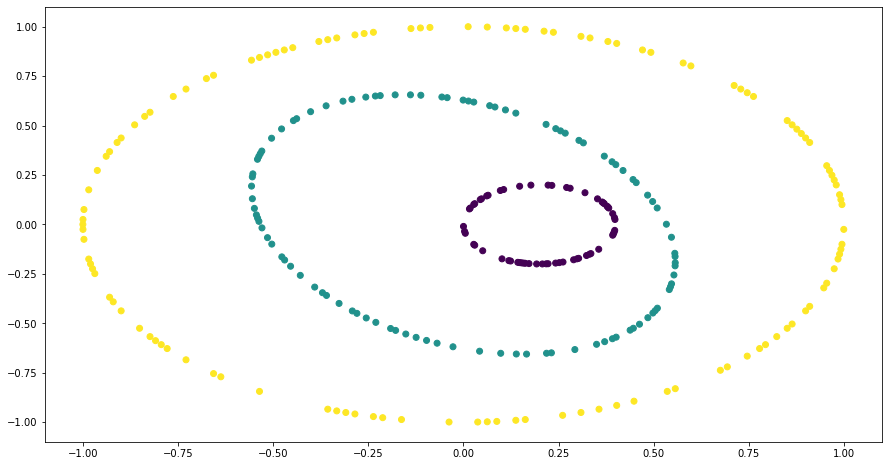

In [6]:
plt.figure(figsize=(15, 8))
plt.scatter(data1[:, 0], data1[:, 1], c=data1[:, 2])
plt.show()

#### Обучающая, тестовая и валидационная выборка
Разобьём датасет на обучающую, валидационную и тестовую выборку в соотношении $70\%-20\%-10\%$.

In [7]:
train, val, test = np.split(data1, [int(.7*len(data1)), int(.9*len(data1))])

In [8]:
train.shape, val.shape, test.shape

((196, 3), (56, 3), (28, 3))

Выделяем для каждой выборке признаки (фичи) и таргеты (лейблы).

In [9]:
X_train = train[:, :2]
y_train = train[:, 2]

X_test = test[:, :2]
y_test = test[:, 2]

X_val = val[:, :2]
y_val = val[:, 2]

### Обучение модели

Будем использовать двухслойный перцептрон. В скрытом слое будет 20 нейронов согласно задания. В качестве функции активации будем использовать Relu, алгоритм обучения - Adam, в качестве лосса - кросс-энтропию.

In [10]:
model1 = keras.Sequential([
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(3, activation='softmax'),
])

In [11]:
model1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='Adam',
    metrics='accuracy'
)

In [12]:
train_info1 = model1.fit(X_train, y_train, batch_size=1, epochs=500, validation_data=(X_val, y_val), shuffle=True, verbose=0)

#### Функция построения графиков лосса и accuracy на обучающей и валидационной выборке.

In [13]:
def create_metrics_plot(train_info):
    plt.figure(figsize=(15, 8))

    plt.subplot(1, 2, 1)
    loss_history = train_info.history['loss']
    val_loss_history = train_info.history['val_loss']
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(range(1, len(loss_history) + 1), loss_history, label='train')
    plt.plot(range(1, len(loss_history) + 1), val_loss_history, label='val')
    plt.grid()
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    acc_history = train_info.history['accuracy']
    val_acc_history = train_info.history['val_accuracy']
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.plot(range(1, len(acc_history) + 1), acc_history, label='train')
    plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label='val')
    plt.grid()
    plt.legend()
    plt.title('Accuracy')

    plt.show()

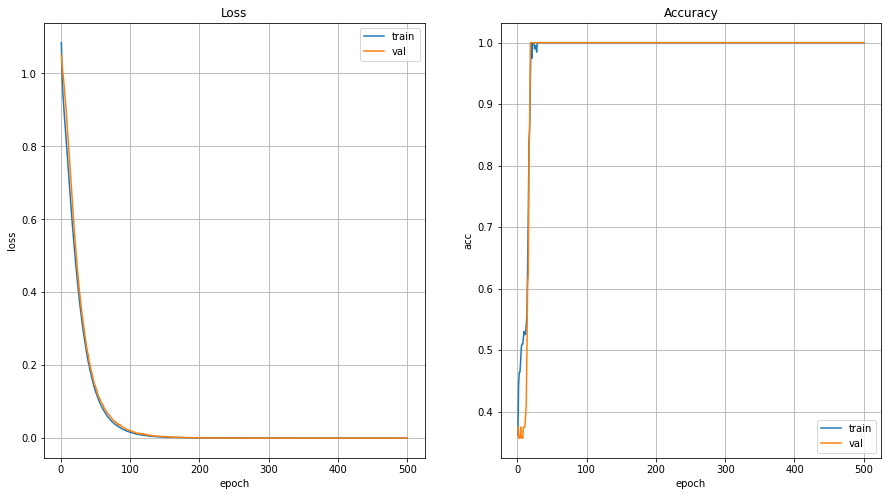

In [14]:
create_metrics_plot(train_info1)

In [35]:
print("Точность на валидационной выборке =", train_info1.history['val_accuracy'][-1])

Точность на валидационной выборке = 1.0


### Результаты работы модели

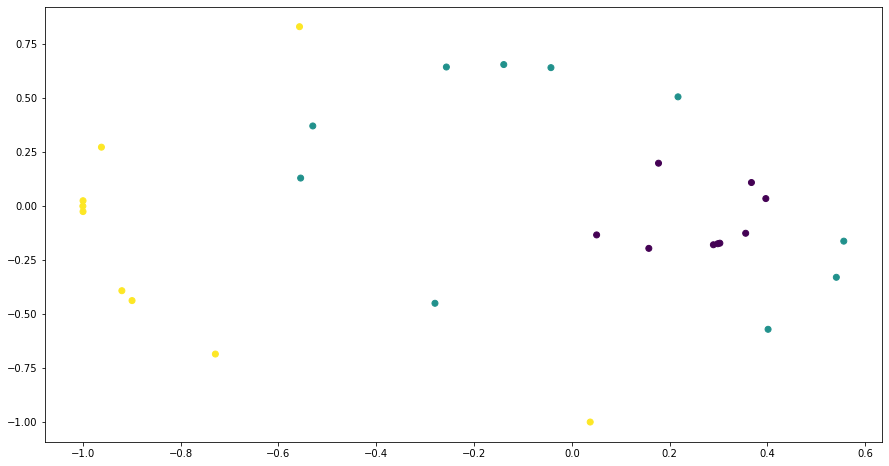

In [16]:
plt.figure(figsize=(15, 8))
plt.scatter(X_test[:, 0], X_test[:, 1], c=np.argmax(model1.predict(X_test, verbose=0), axis=1))
plt.show()

In [17]:
print("Точность на тестовой выборке =", (np.argmax(model1.predict(X_test, verbose=0), axis=1) == y_test).mean())

Точность на тестовой выборке = 1.0


Все точки тестовой выборки модель предсказала верно.

Произведём классификацию точек области $[−1.2, 1.2]×[−1.2, 1.2]$. Для этого зададим сетку для указанной области с шагом $h = 0.025$. Рассчитаем выход сети для всех узлов сетки.

In [18]:
h = 0.025

grid = [model1.predict(np.array([[i, j]]), verbose=0).round(1)
        for i in np.arange(-1.2, 1.2 + h, h)
        for j in np.arange(-1.2, 1.2 + h, h)]

In [19]:
x_сoords = np.arange(-1.2, 1.2 + h, h)
y_coords = np.arange(-1.2, 1.2 + h, h)

xx, yy = np.meshgrid(x_сoords, y_coords)

In [20]:
colors = np.array(grid).reshape((len(grid), 3))
colors.shape

(9409, 3)

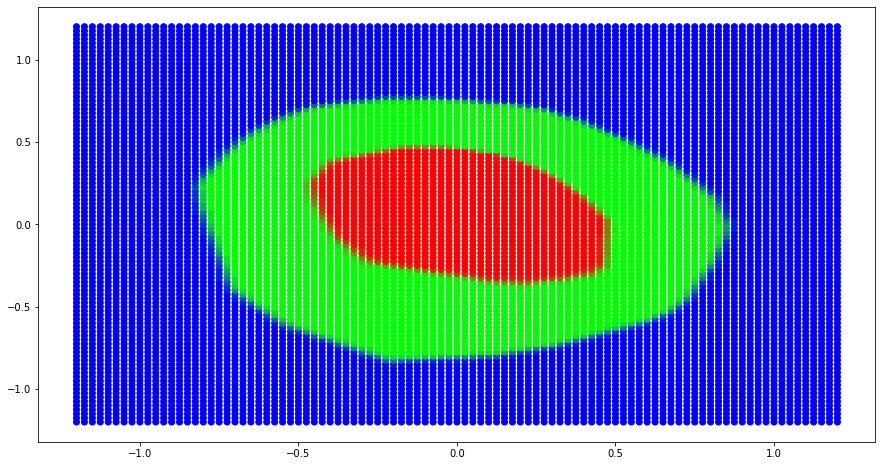

In [21]:
plt.figure(figsize=(15, 8))
plt.scatter(xx, yy, c=colors)
plt.show()

Как видно, модель предсказала точки сетки таким образом,что примерно получается картинка, похожая на сгенерированный датасет с эллипсами.

### Задание 2.
Аппроксимировать функцию. Произвести обучение с помощью одного из методов первого порядка

In [22]:
def X(t):
    return np.sin(t**2 - 7 * t)

t_start = 0
t_end = 5
h = 0.025

Создадим датасет и поделим его на обучающую и валидационную выборку в соотношении $90\%-10\%$.

In [23]:
t = np.linspace(t_start, t_end, int((t_end - t_start) / h))
x = X(t)

In [24]:
train_len = int(t.shape[0] * 0.9)

t_train = t[:train_len]
t_val = t[train_len:]

x_train = x[:train_len]
x_val = x[train_len:]

In [25]:
t_train = np.expand_dims(t_train, 1)
t_val = np.expand_dims(t_val, 1)

#### Обучение модели
В качестве алгоритма обучения возьмем Adam (метод оптимизации 1 порядка), функцию активацию Tanh, количество слоёв - 3.

In [26]:
model2 = keras.Sequential([
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dense(64, activation='tanh'),
    keras.layers.Dense(1),
])

In [27]:
model2.compile(
    loss='mse',
    optimizer='Adam',
    metrics=tf.keras.metrics.RootMeanSquaredError(),
)

In [28]:
train_info2 = model2.fit(t_train, x_train, batch_size=4, epochs=1000, validation_data=(t_val, x_val), verbose=0)

#### Функция построения графиков лосса и accuracy на обучающей и валидационной выборке.

In [29]:
def create_metrics_plot2(train_info):
    plt.figure(figsize=(15, 8))

    plt.subplot(1, 2, 1)
    loss_history = train_info.history['loss']
    val_loss_history = train_info.history['val_loss']
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(range(1, len(loss_history) + 1), loss_history, label='train')
    plt.plot(range(1, len(loss_history) + 1), val_loss_history, label='val')
    plt.grid()
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    acc_history = train_info.history['root_mean_squared_error']
    val_acc_history = train_info.history['val_root_mean_squared_error']
    plt.xlabel('epoch')
    plt.ylabel('RMSE')
    plt.plot(range(1, len(acc_history) + 1), acc_history, label='train')
    plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label='val')
    plt.grid()
    plt.legend()
    plt.title('RMSE')

    plt.show()

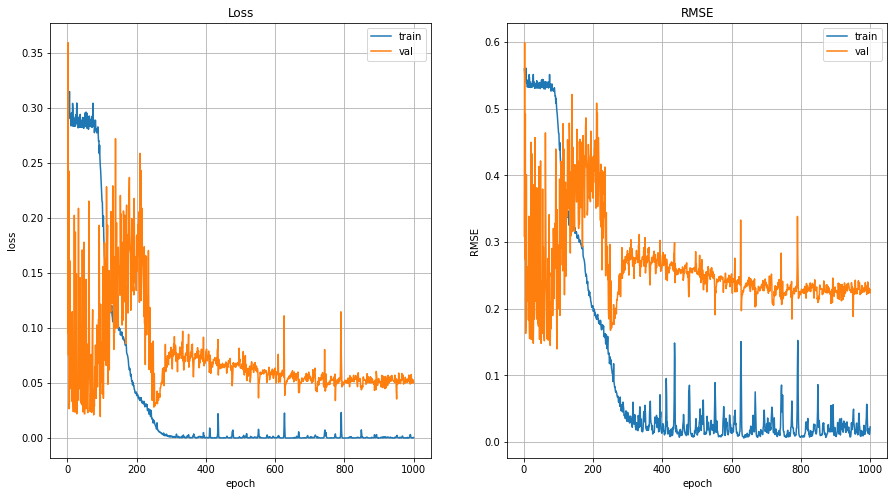

In [30]:
create_metrics_plot2(train_info2)

In [31]:
print("RMSE на валидационной выборке =", train_info2.history['val_root_mean_squared_error'][-1])

RMSE на валидационной выборке = 0.2240196168422699


### Результаты работы модели на обучающей выборке

In [32]:
def build_results_plot(model, t, X):
    plt.figure(figsize=(15, 8))

    plt.plot(t, X(t), label='true')
    plt.plot(t, model.predict(t), label='pred')

    plt.grid()
    plt.legend()
    plt.show()

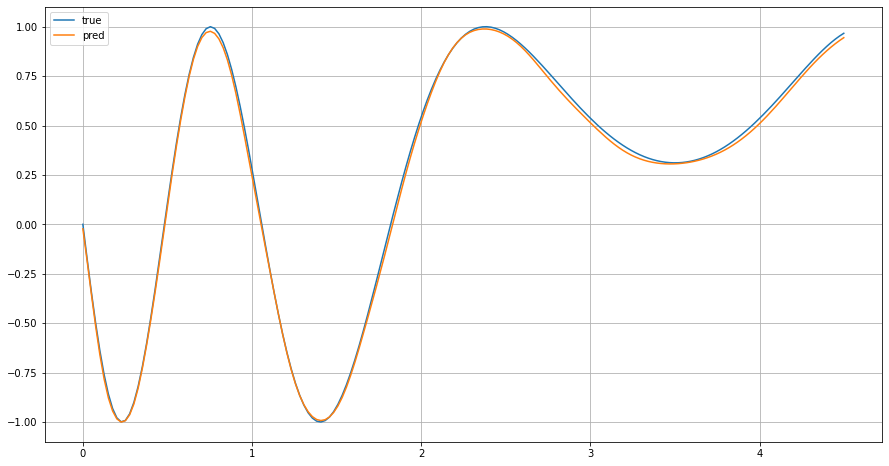

In [33]:
build_results_plot(model2, t_train, X)

### Результаты работы модели на валидационной выборке

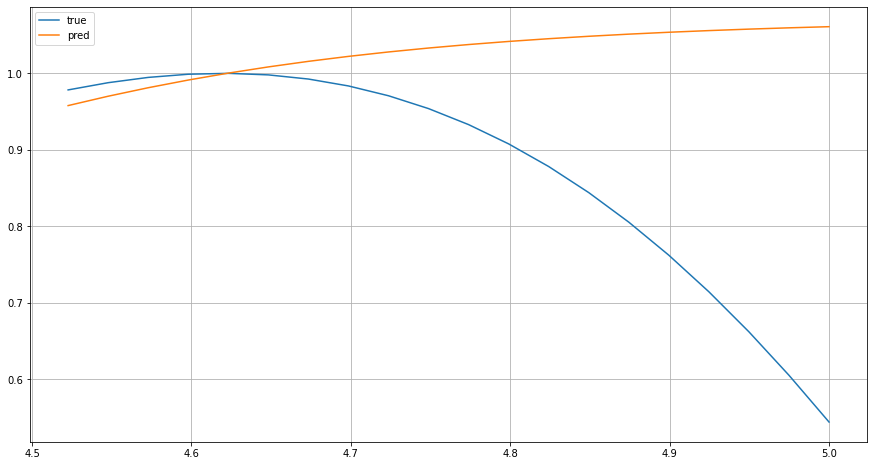

In [34]:
build_results_plot(model2, t_val, X)

Как видно из графика, на валидационной выборке модель плохо справляется.

### Выводы
В ходе данной лабораторной работы реализовал многослойную нейронную сеть для классификации точек с линейно не разделяемыми классами.  

Также обучил модель для аппроксимации заданной вариантом ЛР функции с помощью метода первого порядка Adam.  

Полученные результаты модели аппроксимировать нелинейную функцию можно проанализировать следующим образом: наша многослойная нейронная сеть не очень хорошо справилась с закруглением функции - модель продолжала строить функцию по прямой.  

RMSE на валидационной выборке: 0.224